# Understanding Deepfakes with Keras

![DCGAN](DCGAN.png)

# Task 1: Importing Libraries and Helper Functions

Please note: If you haven't already, please install the required packages by executing the code cell below.

In [1]:
%matplotlib notebook

import tensorflow as tf
import numpy as np
import os
import tfutils

from matplotlib import pyplot as plt
from tensorflow.keras.layers import Dense, Flatten, Conv2D, BatchNormalization
from tensorflow.keras.layers import Conv2DTranspose, Reshape, LeakyReLU
from tensorflow.keras.models import Model, Sequential
from PIL import Image

print('TensorFlow version:', tf.__version__)

TensorFlow version: 2.1.0


# Task 2: Importing and Plotting the Data

In [2]:
(x_train, y_train), (x_test, y_test) = tfutils.datasets.mnist.load_data(one_hot = False)
x_train = tfutils.datasets.mnist.load_subset([0], x_train, y_train)
x_test = tfutils.datasets.mnist.load_subset([0], x_test, y_test)
x = np.concatenate([x_train, x_test], axis = 0)

<IPython.core.display.Javascript object>


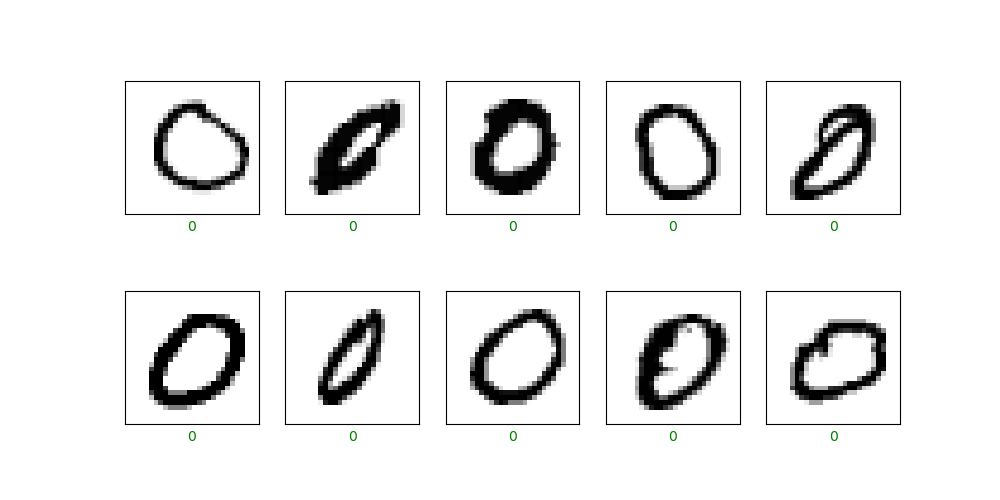

In [3]:
tfutils.datasets.mnist.plot_ten_random_examples(plt, x, np.zeros((x.shape[0], 1))).show()

# Task 3: Discriminator

![Artist and Critic](artist_critic.png)

In [4]:
discriminator = Sequential([
    Conv2D(64, 3, strides = 2, input_shape = (28, 28, 1)),
    LeakyReLU(),
    BatchNormalization(),
    Conv2D(128, 5, strides = 2),
    LeakyReLU(),
    BatchNormalization(),
    Conv2D(256, 5, strides = 2),
    LeakyReLU(),
    BatchNormalization(),
    Flatten(),
    Dense(1, activation = 'sigmoid')
])

opt = tf.keras.optimizers.Adam(lr = 2e-4, beta_1 = 0.5)
discriminator.compile(loss = 'binary_crossentropy', optimizer = opt, metrics = ['accuracy'])
discriminator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 13, 13, 64)        640       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 13, 13, 64)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 13, 13, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 5, 5, 128)         204928    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 5, 5, 128)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 5, 5, 128)         512       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1, 1, 256)         8

# Task 4: Generator

In [5]:
generator = Sequential([
    Dense(256, activation = 'relu', input_shape = (1, )),
    Reshape((1, 1, 256)),
    Conv2DTranspose(256, 5, activation = 'relu'),
    BatchNormalization(),
    Conv2DTranspose(128, 5, activation = 'relu'),
    BatchNormalization(),
    Conv2DTranspose(64, 5, strides = 2, activation = 'relu'),
    BatchNormalization(),
    Conv2DTranspose(32, 5, activation = 'relu'),
    BatchNormalization(),
    Conv2DTranspose(1, 4, activation = 'sigmoid')
])
generator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               512       
_________________________________________________________________
reshape (Reshape)            (None, 1, 1, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 5, 5, 256)         1638656   
_________________________________________________________________
batch_normalization_3 (Batch (None, 5, 5, 256)         1024      
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 9, 9, 128)         819328    
_________________________________________________________________
batch_normalization_4 (Batch (None, 9, 9, 128)         512       
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 21, 21, 64)       

<IPython.core.display.Javascript object>


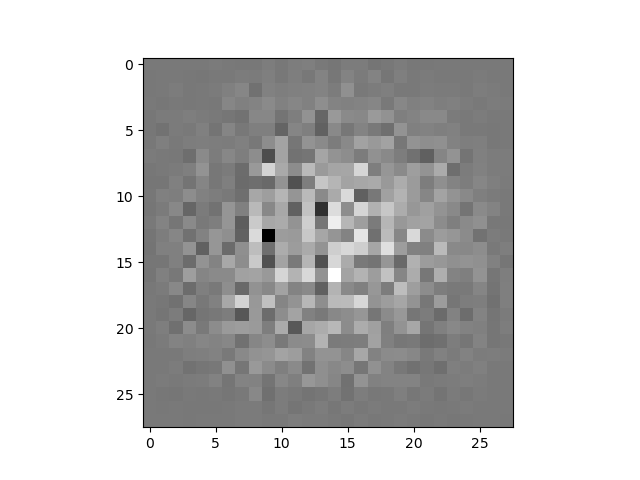

In [6]:
noise = np.random.randn(1, 1)
gen_image = generator.predict(noise)[0]
plt.figure()
plt.imshow(np.reshape(gen_image, (28, 28)), cmap = 'binary')
plt.show()

# Task 5: Generative Adversarial Network (GAN)

In [7]:
input_layer = tf.keras.layers.Input(shape = (1, ))
gen_out = generator(input_layer)
disc_out = discriminator(gen_out)

gan = Model(
    input_layer,
    disc_out
)
discriminator.trainable = False
gan.compile(loss = 'binary_crossentropy', optimizer = opt, metrics = ['accuracy'])
gan.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 28, 28, 1)         2717025   
_________________________________________________________________
sequential (Sequential)      (None, 1)                 1027073   
Total params: 3,744,098
Trainable params: 2,716,065
Non-trainable params: 1,028,033
_________________________________________________________________


# Tasks 6 and 7: Training the GAN

<IPython.core.display.Javascript object>


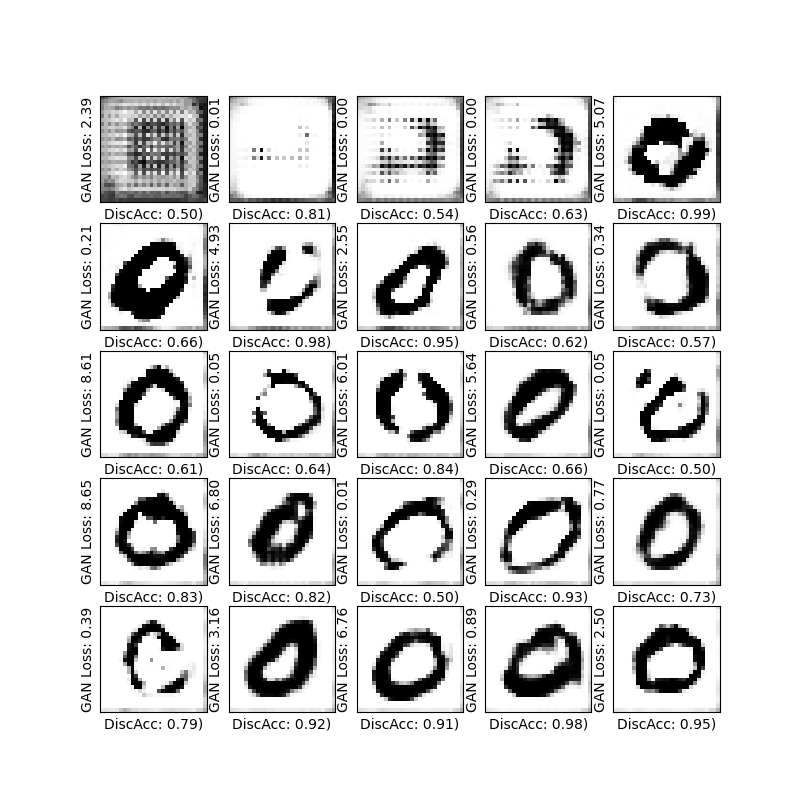

In [8]:
epochs = 25
batch_size = 128
steps_per_epoch = int(2 * x.shape[0] / batch_size) # Why 2 * ?: each epoch only half examples are used for training
dp = tfutils.plotting.DynamicPlot(plt, 5, 5, (8, 8))

for e in range(0, epochs):
    dp.start_of_epoch(e)
    
    for step in range(0, steps_per_epoch):
        true_examples = x[int(batch_size / 2) * step:int(batch_size / 2) * (step + 1)]
        true_examples = np.reshape(true_examples, (true_examples.shape[0], 28, 28, 1))
        noise = np.random.randn(int(batch_size / 2), 1)
        gen_examples = generator.predict(noise)
        x_batch = np.concatenate([gen_examples, true_examples], axis = 0)
        y_batch = np.array([0] * int(batch_size / 2) + [1] * int(batch_size / 2))
        indices = np.random.choice(range(batch_size), batch_size, replace = False)
        x_batch = x_batch[indices]
        y_batch = y_batch[indices]
        
        discriminator.trainable = True
        discriminator.train_on_batch(x_batch, y_batch)
        discriminator.trainable = False
        
        loss, _ = gan.train_on_batch(noise, np.ones((int(batch_size / 2), 1)))
        _, acc = discriminator.evaluate(x_batch, y_batch, verbose = False) # When generator does well, discriminator will get worse
    
    noise = np.random.randn(1, 1)
    gen_image = generator.predict(noise)[0]
    gen_image = np.reshape(gen_image, (28, 28))
    dp.end_of_epoch(gen_image, 'binary', 'DiscAcc: {:.2f})'.format(acc), "GAN Loss: {:.2f}".format(loss))